In [1]:
import earthaccess
import fiona
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pandarallel import pandarallel
# import zipfile
# from itertools import chain

/work/pi_cjgleason_umass_edu/.conda/envs/narrowPIXC/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# pd.reset_option('display.max_columns', 0)

In [2]:
def specialClip(sj):
    left = gpd.GeoSeries(sj.geometry)
    right = gpd.GeoSeries(sj.geom)
    geometry_clip = left.clip(right)
    return geometry_clip

### Make table of intersecting NHD HUC4 and SWOT tiles

#### HUC Boundaries

In [3]:
# Read in HUC4 boundaries (no Great Lakes)
data_path = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/all_wbd_no_great_lakes.parquet'
wbd = gpd.read_parquet(path=data_path)

In [4]:
# Project CRS to WGS 84 / Pseudo-Mercator
wbd_wm = wbd.to_crs(epsg=3857)

#### Make lightweight version of SWOT Science Orbit tiles

In [ ]:
data_path_sci = '/nas/cee-water/cjgleason/data/SWOT/tiles/swot_science_coverage_20240319.kmz'
layers = fiona.listlayers(data_path_sci)

In [ ]:
# Initialize lists
d = []

# Loop through indices and store in lists
for i in range(3,len(layers[3:])+1):

    # Read in the current SWOT pass
    pass_tiles = gpd.read_file(filename=data_path_sci, layer=layers[i], engine='pyogrio')
    
    subset = pass_tiles.iloc[:,[0,-1]]

    # Append to lists
    d.append(subset)

# Merge GeoDataFrames
all_tiles = pd.concat(d)

In [ ]:
all_tiles

In [ ]:
# Write out lightweight files as parquet and GeoPackage
save_path = '/nas/cee-water/cjgleason/data/SWOT/tiles/'
all_tiles.to_parquet(path=os.path.join(save_path, 'swot_science_coverage_merged.parquet'))
all_tiles.to_file(filename=os.path.join(save_path, 'swot_science_coverage_merged.gpkg'), driver='GPKG')

### Join tiles to HUC4 to make reference table

In [5]:
data_path = '/nas/cee-water/cjgleason/data/SWOT/tiles/swot_science_coverage_merged.parquet'
# Read in simplified SWOT science tiles
sci_tiles = gpd.read_parquet(path=data_path)

In [6]:
# Project CRS to WGS 84 / Pseudo-Mercator
sci_tiles_wm = sci_tiles.to_crs(epsg=3857)

In [7]:
# Get bounding box of NHDPlus HR watersheds
bounds_wbd = wbd_wm.total_bounds

In [8]:
# Clip SWOT science tiles to counding box
sci_tiles_clip = gpd.clip(gdf=sci_tiles_wm, mask=bounds_wbd)

In [9]:
# Copy geometry column for WBD as sjoin will discard it
wbd_wm['geom'] = wbd_wm.geometry

In [10]:
# Join the SWOT tiles and HUC4 boundaries by intersection
joined = gpd.sjoin(sci_tiles_clip, wbd_wm, how='inner', predicate='intersects')

In [11]:
joined = joined.reset_index().rename(columns={'index': 'index_old'})

In [12]:
pandarallel.initialize()

INFO: Pandarallel will run on 128 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
# left = gpd.GeoSeries(joined.iloc[0].geometry)
# right = gpd.GeoSeries(joined.iloc[0].geom)
# clipped = left.clip(right)
# clipped.area / left.area

In [ ]:
# fig, ax = plt.subplots(figsize=(8,8))

# left.plot(ax=ax)
# right.plot(ax=ax, color='k')

In [13]:
joined['geometry_clipped'] = joined.parallel_apply(user_defined_function=specialClip,
                                                   axis=1)

In [14]:
joined['coverage'] = joined.geometry_clipped.area / joined.geometry.area

In [ ]:
cleaned = joined[['Name', 'huc4', 'coverage']].sort_values(by=['Name', 'huc4']).rename(columns={'Name': 'tile'}).reset_index().drop(columns='index')

In [ ]:
cleaned.to_csv('./data/huc4_swot_science_tiles.csv', index=False)

In [ ]:
# joined[joined['coverage'] > 0.90]

### Coverage plots

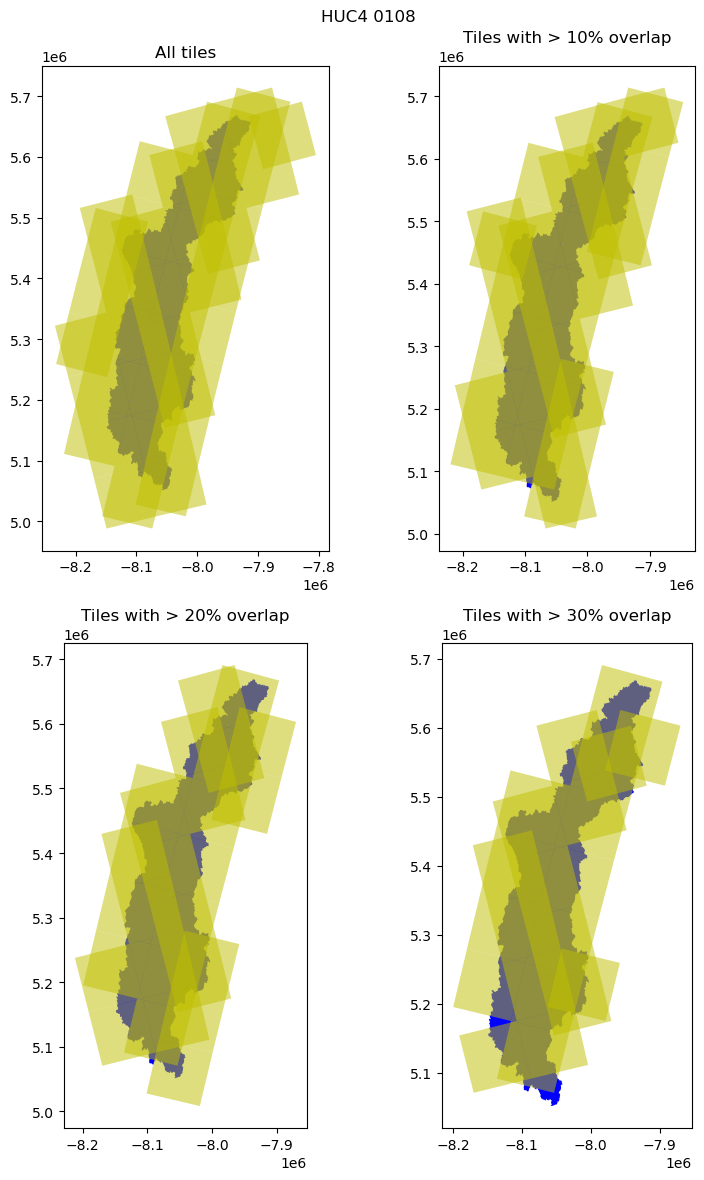

In [15]:
subset = joined[joined['huc4'] == '0108']

huc = gpd.GeoSeries(subset.iloc[0].geom)
huc4 = subset.iloc[0].huc4

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(8,12))

plt.suptitle('HUC4 ' + str(huc4))

huc.plot(ax=ax0, color='b')
gpd.GeoSeries(subset.geometry).plot(ax=ax0, color='y', alpha=0.5)
ax0.set_title('All tiles')

huc.plot(ax=ax1, color='b')
gpd.GeoSeries(subset[subset['coverage'] > 0.1] .geometry).plot(ax=ax1, color='y', alpha=0.5)
ax1.set_title('Tiles with > 10% overlap')

huc.plot(ax=ax2, color='b')
gpd.GeoSeries(subset[subset['coverage'] > 0.2] .geometry).plot(ax=ax2, color='y', alpha=0.5)
ax2.set_title('Tiles with > 20% overlap')

huc.plot(ax=ax3, color='b')
gpd.GeoSeries(subset[subset['coverage'] > 0.3] .geometry).plot(ax=ax3, color='y', alpha=0.5)
ax3.set_title('Tiles with > 30% overlap')

fig.tight_layout()

In [ ]:
subset = joined[joined['huc4'] == '1606']

huc = gpd.GeoSeries(subset.iloc[0].geom)
huc4 = subset.iloc[0].huc4

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(8,12))

plt.suptitle('HUC4 ' + str(huc4))

huc.plot(ax=ax0, color='b')
gpd.GeoSeries(subset.geometry).plot(ax=ax0, color='y', alpha=0.5)
ax0.set_title('All tiles')

huc.plot(ax=ax1, color='b')
gpd.GeoSeries(subset[subset['coverage'] > 0.1] .geometry).plot(ax=ax1, color='y', alpha=0.5)
ax1.set_title('Tiles with > 10% overlap')

huc.plot(ax=ax2, color='b')
gpd.GeoSeries(subset[subset['coverage'] > 0.2] .geometry).plot(ax=ax2, color='y', alpha=0.5)
ax2.set_title('Tiles with > 20% overlap')

huc.plot(ax=ax3, color='b')
gpd.GeoSeries(subset[subset['coverage'] > 0.3] .geometry).plot(ax=ax3, color='y', alpha=0.5)
ax3.set_title('Tiles with > 30% overlap')

fig.tight_layout()

In [ ]:
subset = joined[joined['huc4'] == '1711']

huc = gpd.GeoSeries(subset.iloc[0].geom)
huc4 = subset.iloc[0].huc4

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(8,12))

plt.suptitle('HUC4 ' + str(huc4))

huc.plot(ax=ax0, color='b')
gpd.GeoSeries(subset.geometry).plot(ax=ax0, color='y', alpha=0.5)
ax0.set_title('All tiles')

huc.plot(ax=ax1, color='b')
gpd.GeoSeries(subset[subset['coverage'] > 0.1] .geometry).plot(ax=ax1, color='y', alpha=0.5)
ax1.set_title('Tiles with > 10% overlap')

huc.plot(ax=ax2, color='b')
gpd.GeoSeries(subset[subset['coverage'] > 0.2] .geometry).plot(ax=ax2, color='y', alpha=0.5)
ax2.set_title('Tiles with > 20% overlap')

huc.plot(ax=ax3, color='b')
gpd.GeoSeries(subset[subset['coverage'] > 0.3] .geometry).plot(ax=ax3, color='y', alpha=0.5)
ax3.set_title('Tiles with > 30% overlap')

fig.tight_layout()

In [ ]:
subset = joined[joined['huc4'] == '0309']

huc = gpd.GeoSeries(subset.iloc[0].geom)
huc4 = subset.iloc[0].huc4

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(8,12))

plt.suptitle('HUC4 ' + str(huc4))

huc.plot(ax=ax0, color='b')
gpd.GeoSeries(subset.geometry).plot(ax=ax0, color='y', alpha=0.5)
ax0.set_title('All tiles')

huc.plot(ax=ax1, color='b')
gpd.GeoSeries(subset[subset['coverage'] > 0.1] .geometry).plot(ax=ax1, color='y', alpha=0.5)
ax1.set_title('Tiles with > 10% overlap')

huc.plot(ax=ax2, color='b')
gpd.GeoSeries(subset[subset['coverage'] > 0.2] .geometry).plot(ax=ax2, color='y', alpha=0.5)
ax2.set_title('Tiles with > 20% overlap')

huc.plot(ax=ax3, color='b')
gpd.GeoSeries(subset[subset['coverage'] > 0.3] .geometry).plot(ax=ax3, color='y', alpha=0.5)
ax3.set_title('Tiles with > 30% overlap')

fig.tight_layout()

In [ ]:
subset = joined[joined['huc4'] == '0108']

In [ ]:
joined_clean = joined[['Name', 'huc4']].reset_index().drop(columns='index')

In [ ]:
joined_clean

In [ ]:
# Write out
joined_clean.to_csv(path_or_buf='./data/huc4_swot_science_tiles.csv', index=False)

In [ ]:
ne_mask = joined['huc4'].str.startswith('01')
ne_tiles = joined[ne_mask]

In [ ]:
# ne_tiles

In [ ]:
ne_wbd_mask = wbd['huc4'].str.startswith('01')
ne_hucs = wbd[ne_wbd_mask]

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
ne_hucs.plot(ax=ax)
ne_tiles.plot(ax=ax, cmap='hsv', alpha=0.2)

plt.savefig('../oops/huc2_01_swot_science.png')

#### Merge data

In [ ]:
# First three layers are 'SWOT Coverage - Science Orbit', 'Passes', 'Tiles'
# Each subsequent layer represents a single SWOT pass
# Reading in more than one pass at a time crashed Jupyter no matter how much RAM I give it

# Loop through all of the SWOT passes and make a list of all the tiles
# and the HUC4 they intersect

huc4s = []
tiles = []

for i in range(3,len(layers[3:])+1):
    print(i)
    
    # Read in the current SWOT pass
    pass_tiles = gpd.read_file(filename=data_path0, layer=layers[i], engine='pyogrio')
    pass_tiles = pass_tiles.to_crs(epsg=3857)
    
    # Sjoin with the NHD WBD to find intersection
    temp = gpd.sjoin(pass_tiles, wbd)
    
    if not temp.empty:
        huc4s.append(temp.huc4.values)
        tiles.append(temp.Name.values)

In [ ]:
tiles[0]

In [ ]:
def flatten_chain(matrix):
    return list(chain.from_iterable(matrix))

In [ ]:
na_tiles = pd.DataFrame(flatten_chain(tiles), index=flatten_chain(huc4s))

In [ ]:
na_tiles = na_tiles.reset_index().rename(columns={0: 'tiles', 'index': 'huc4'})

In [ ]:
# Write out
na_tiles.to_csv('./data/huc4_swot_tiles.csv')

#### SWOT Tiles

In [ ]:
data_path0 = '/nas/cee-water/cjgleason/data/SWOT/tiles/swot_science_coverage_20240319.kmz'
layers = fiona.listlayers(data_path0)

In [ ]:
pass_tiles = gpd.read_file(filename=data_path0, layer=layers[3], engine='pyogrio')

In [ ]:
pass_tiles.iloc[:,[0,-1]]

### Check that NE tiles match what I previously found

In [ ]:
# Data path
data_path = './data/huc4_swot_tiles.csv'

In [ ]:
# Define dtypes for lookup tables to preserve leading zeros
dtype_dic= {'Unnamed: 0': str, 'huc4': str}

In [ ]:
# Read in HUC lookup table
# lookup = pd.read_csv(os.path.join(mdata_path,
#                                   'HUC4_lookup_no_great_lakes.csv'),
#                      dtype=dtype_dic)
na_tiles = pd.read_csv(data_path, dtype=dtype_dic).drop(columns='Unnamed: 0')

In [ ]:
na_tiles

In [ ]:
# Get NE tiles (HUC2 01)
ne_mask = na_tiles['huc4'].str.startswith('01')
ne_tiles = list(set(na_tiles[ne_mask]['tiles']))

In [ ]:
na_tiles[ne_mask]['huc4'].unique()

In [ ]:
directory = '/nas/cee-water/cjgleason/fiona/narrow_rivers_PIXC_data/PIXC_v2_0_HUC2_01_stats'

files = []
for file in os.listdir(directory):
    if 
    files.append(file)

print(f"There are {str(len(files))} original files in directory.")

# # Make DataFrame of filenames
# granules = pd.DataFrame({'files': files})
# granules['cycle'] = granules['files'].str.slice(16, 19)
# granules['pass'] = granules['files'].str.slice(20, 23)
# granules['tile'] = granules['files'].str.slice(24, 28)
# granules['version'] = granules['files'].str.slice(-10, -6)
# granules['counter'] = granules['files'].str.slice(-5, -3) 

In [ ]:
# Make DataFrame of filenames
granules = pd.DataFrame({'files': files})

In [ ]:
granules['pass_tile'] = granules['files'].str.slice(20,28).values
granules['pass'] = granules['files'].str.slice(20,23).values

In [ ]:
# Drop checkpoint file (fix above)
granules = granules[granules['pass_tile'] != '']

In [ ]:
passes = list(granules['pass'].unique())

In [ ]:
passes.sort()

In [ ]:
passes

In [ ]:
# Get all of the unique SWOT tiles in the NE
tiles = granules['pass_tile'].values
tiles = list(set(tiles))

In [ ]:
tiles.sort()

In [ ]:
len(tiles)

In [ ]:
len(ne_tiles)

In [ ]:
extra = list(set(tiles) - set(ne_tiles))

In [ ]:
len(extra)

In [ ]:
extra_less = list(set(ne_tiles) - set(tiles))

In [ ]:
extra_less